# Download graph from Osmnx

In [4]:
import osmnx as ox
import pandas as pd
import requests
import numpy as np
import requests

In [5]:
ECOBICI_API = "https://gbfs.mex.lyftbikes.com/gbfs/gbfs.json"
response = requests.get(ECOBICI_API,timeout=2)
api_urls = {x['name']: x['url'] for x in response.json()['data']['en']['feeds']}

In [6]:
response = requests.get(api_urls['station_information'],timeout=3.1)
stations = pd.DataFrame.from_dict(response.json()['data']['stations'])
stations['short_name'] = stations['short_name'].str.pad(width=3, side='left', fillchar='0')
stations.set_index("station_id",inplace=True)
stations.sample(5)

,external_id,name,short_name,lat,lon,rental_methods,capacity,electric_bike_surcharge_waiver,is_charging,eightd_has_key_dispenser,has_kiosk
station_id,,,,,,,,,,,
585,464ec58d-de42-43ce-be29-b2ffeae15f64,CE-594 Xochicalco - Obrero Mundial,594,19.402277,-99.153294,"[CREDITCARD, KEY]",31,False,False,False,True
407,07e4fca7-239e-4ecf-ae82-ead6d0078456,CE-395 San Lorenzo-Martín Mendalde,395,19.373725,-99.169807,"[CREDITCARD, KEY]",31,False,False,False,True
173,99a11305-b58e-4b4a-9d52-46178d17de62,CE-032 Londres - Sevilla,032,19.422686,-99.169983,"[CREDITCARD, KEY]",35,False,False,False,True
674,15c42e7e-58df-4881-869f-c65023db96bf,CE-515 Tebas-C. Salónica,515,19.469622,-99.184082,"[CREDITCARD, KEY]",19,False,False,False,True
653,a136d3c5-1405-47f6-a8bb-b7f732a6f990,CE-632 Victor Hugo - Sevilla,632,19.370891,-99.151577,"[CREDITCARD, KEY]",27,False,False,False,True


In [7]:
def calculate_centroid_np(coords):
    coords = np.array(coords)
    return coords.mean(axis=0)

points = stations.apply(lambda x: (x.lon,x.lat),axis=1).tolist()
centroid = calculate_centroid_np(points)
print("Centroid:", tuple(centroid))


Centroid: (np.float64(-99.16756223761703), np.float64(19.408344823157517))


In [8]:
max_lat_distance = float(stations.lat.apply( lambda x: x - centroid[1]).abs().max())

In [9]:
max_lon_distance = float(stations.lon.apply( lambda x: x - centroid[0]).abs().max())

In [10]:
avg_lon,avg_lat = stations[['lon','lat']].mean()

In [11]:
import math

def lon_diff_to_km(delta_lon, latitude_deg):
    return 111.320 * math.cos(math.radians(latitude_deg)) * delta_lon
def lat_diff_to_km(delta_lat):
    return 111 * delta_lat

In [12]:
lon_diff_to_km(max_lon_distance,avg_lat)

4.75442558923858

In [13]:
lat_diff_to_km(max_lat_distance)

7.130398370484254

In [15]:
west,south,east,north

(np.float64(-99.282845),
 np.float64(19.274107),
 np.float64(-99.060918),
 np.float64(19.541112000000002))

In [ ]:
buffer = 0.07
north = stations.lat.max() + buffer
south = stations.lat.min() - buffer
east = stations.lon.max()+buffer
west = stations.lon.min()-buffer

G = ox.graph_from_bbox((west, south, east, north), network_type="bike")

KeyboardInterrupt: 

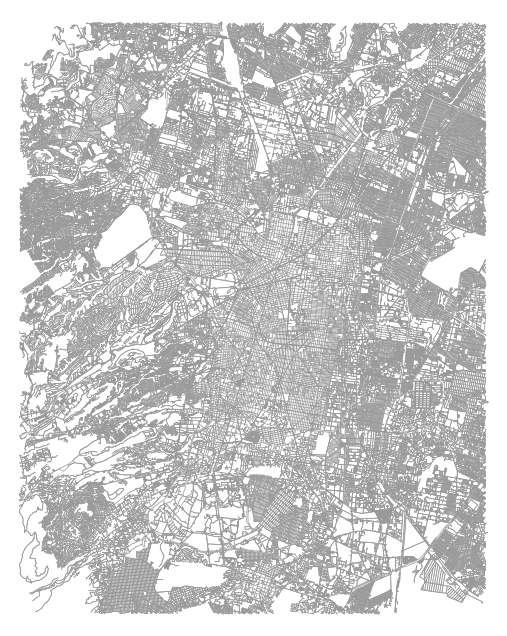

In [12]:
G_proj = ox.project_graph(G)
fig, ax = ox.plot_graph(G_proj,node_size=0, edge_linewidth=0.5,bgcolor="white")

In [14]:
stations['node'] = stations.apply(lambda x: ox.distance.nearest_nodes(G, x.lon,x.lat),axis=1)

In [ ]:
G_proj.get_edge_data()

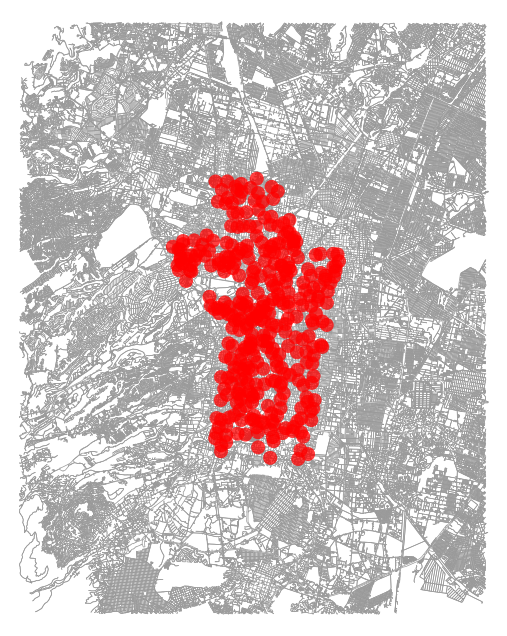

In [37]:
nodes_to_highlight = stations.sample(frac=0.5).node.unique()
nodes_to_highlight = [[int(x)] for x in nodes_to_highlight ]

fig, ax = ox.plot_graph_routes(G_proj,nodes_to_highlight,node_size=0.01, edge_linewidth=0.5,bgcolor="white",)

In [38]:
ox.save_graphml(G, filepath="graphs/mexico_city.graphml")
ox.save_graphml(G_proj, filepath="graphs/mexico_city_projected.graphml")

In [39]:
stations.to_csv("data/new_stations_with_nodes.csv",index=True)